# Examine Sonalleve HIFU ablations from single-focus vs. multi-focus

 Trajectories modelled after work of Quesson, Mougenot  

In [1]:
import h5py
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections
from matplotlib import image
 
import matplotlib.animation as animation;
    
from math import *;

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\BioHeatCpp\\PBHEswig\\x64')
import ablation_utils
import geom
import sonalleve
import transducers
import PBHEswig
from countlines import countlines

import imagemanip as imp;


%matplotlib inline

In [2]:
db = 0.15
da = 0.15

ecc = db/da

dt = 0.1
tmax0=90
rmax=1.6

omega0 = (rmax**2)*ecc*pi/tmax0

dwell_time0=1.0
t0 = np.arange(0,tmax0,dwell_time0)

tmax1=30
dwell_time1=0.5

da1 = 0.2
db1 = 0.2
ecc1 = db1/da1

omega1 = (rmax**2)*ecc1*pi/tmax1
t1 = np.arange(0,tmax1,dwell_time1)
ksi = np.sqrt((4*pi*omega0/(ecc*da*da))*t0)
ksi1 = np.sqrt((4*pi*omega1/(ecc*da1*da1))*t1) 

x0 = da*(ksi/(2*pi))*np.cos(ksi)
y0 = db*(ksi/(2*pi))*np.sin(ksi)

x1 = da1*(ksi1/(2*pi))*np.cos(ksi1) 
y1 = db1*(ksi1/(2*pi))*np.sin(ksi1)


#x = np.arange(-0.6, 0.6, 1.2/len(t))
#y = np.zeros_like(x)
coords0 = np.zeros([len(t0), 3])
coords0[:,0]=x0/100.0
coords0[:,1]=y0/100.0

coords1 = np.zeros([len(t1), 3])
coords1[:,0]=x1/100.0
coords1[:,1]=y1/100.0




In [3]:
npass0=4
ksi0Step = np.zeros_like(ksi)
if npass0>0:
    ksi0Step[1:-1] = (ksi[1:-1] - ksi[0:-2])/(npass0)

coords0Rn = np.zeros([npass0,len(t0), 3])
for n in range(0,npass0):
    ksi_n = ksi + n*ksi0Step
    xn = da*(ksi_n/(2*pi))*np.cos(ksi_n) 
    yn = db*(ksi_n/(2*pi))*np.sin(ksi_n)
    
    coords0Rn[n,:,0]=xn/100.0
    coords0Rn[n,:,1]=yn/100.0

npass1=4
ksi1Step = np.zeros_like(ksi1)
if npass1>0:
    ksi1Step[1:-1] = (ksi1[1:-1] - ksi1[0:-2])/(npass1)

coords1Rn = np.zeros([npass1,len(t1), 3])
for n in range(0,npass1):
    ksi_n = ksi1 + n*ksi1Step
    xn = da1*(ksi_n/(2*pi))*np.cos(ksi_n) 
    yn = db1*(ksi_n/(2*pi))*np.sin(ksi_n)
    
    coords1Rn[n,:,0]=xn/100.0
    coords1Rn[n,:,1]=yn/100.0


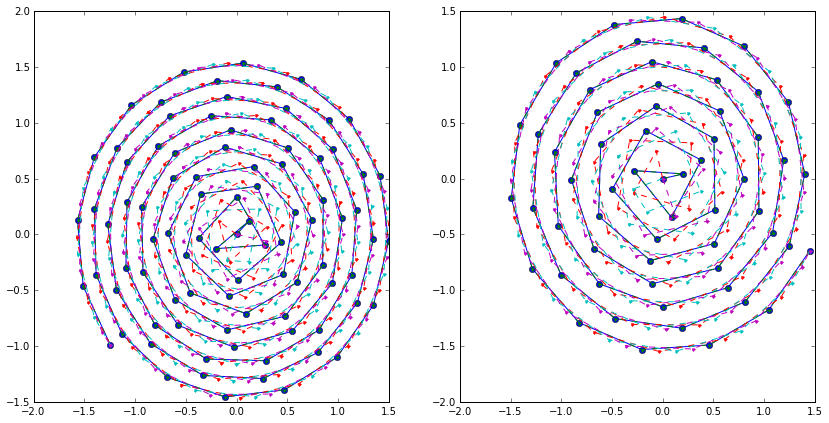

In [4]:
fig=plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(x0,y0,'o-')
plt.plot(np.transpose(100*coords0Rn[:,:,0]),np.transpose(100*coords0Rn[:,:,1]),'--.');
plt.subplot(122)
plt.plot(x1,y1,'o-')
plt.plot(np.transpose(100*coords1Rn[:,:,0]),np.transpose(100*coords1Rn[:,:,1]),'--.');

In [26]:
Rn = geom.getRotZYZarray(pi/2,0,0)
coorsRn = 100*coords1.dot((Rn))

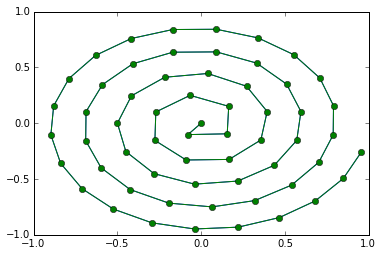

In [35]:
plt.plot(x0,y0,'.-')
plt.plot(x1,y1,'o-')


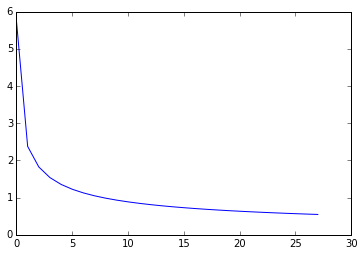

In [31]:
plt.plot(ksi1[1:-1]-ksi1[0:-2])

In [47]:
da


0.2

In [5]:
t0

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.])

In [5]:
def isarray(a):
    try:
        shp = a.shape
        return True
    except:
        return False

def sonication_heating(T, Tdot, CEM, duration, T0=None, CEMinit=None, Tmax=None, Freeflow=0):
    
    if T0 is not None:
        if isarray(T0):
            T=T0
        else:
            T[:] = T0
    if CEMinit is not None:
        if isarray(CEMinit):
            CEM=CEMinit
        else:
            CEM[:]=CEMinit
    if Tmax is None:
        Tmax = np.zeros_like(CEM)
    
    
    time=0
    ti=0
    buffsize=T.shape[0]
    tstep=dt*buffsize
    while time<duration :

        print( '%d%%' % (time/duration *100.0), end='\r')
        
        if (time + tstep > duration):
            buffsize = ceil((duration-time)/dt)
            tstep = dt*buffsize
            

        PBHEswig.pbheSolve(Freeflow,dt,dx,dy,dz, Tmesh, Tdotmesh, kmesh, rhoCpmesh, 37.0, perfRate,0,buffsize-1 )
        Rbase[:]=4
        Rbase[np.where(T[0:,buffsize] > 43.0, True, False)] = 2
        
        update = np.where(T[buffsize-1] > Tmax, True, False)
        Tmax[update] = T[buffsize-1][update]

                #time integrate to get the thermal dose
        CEM[:] += (dt/60.0)*np.sum( Rbase**(T[0:buffsize]-43), 0  )

        ti+=1
        time+=tstep
        T[0] = T[buffsize-1]
        
    return (Tmax, time)


def sonication_heating_physical_move(xdcTimes, xdcPoints, uamp, CEM, CEMvst, Tmax=None, frad=0.004, timeZero=0.0, Freeflow=0, Tparam=48):
    
    if Tmax is None:
        Tmax = np.zeros_like(CEM)
    
    CEMvst[:]=0

    ti=0
    
    numSonicationPoints = len(xdcTimes)-1
    
    totalCooling=0
    
    #pre-calc HIFU-induced source term (not actual dT/dt, just what is due to HIFU)
    Pr = sonalleve.calc_pressure_field(k0, uxyz, uamp, xrp, yrp, zrp)
    Iavg = np.abs(Pr)**2 / (2.0*rho*c0)
    Tdot[:] = 2.0*(alpha_acc)*Iavg / (rhoCp)
    
    
    fzonesCentered=list( map ( lambda v: np.where( calcGridDist( v ) < frad), [pcentroid] ) )
    focalPntRise = list( map( lambda ell: np.mean(Tdot[ell]), fzonesCentered ) )
    
    elapsedTime = timeZero
    sonicationEndTimes = np.zeros(numSonicationPoints);
    
    ti=0
    while ti < numSonicationPoints :

        fzones =list( map ( lambda v: np.where( calcGridDist( v ) < frad), [pcentroid + xdcPoints[ti]] ) )
        TfocFilt =list( map( lambda ell: np.mean(T[0][ell]), fzones ) )
        
        dwell = min( list(map(lambda a,b: (Tparam-a)/b, TfocFilt,focalPntRise)) )
        if dwell > 20.0:
            dwell = 20.0 
           
        #dwell = xdcTimes[ti+1] - xdcTimes[ti];
        
        monitorTemp = np.mean(T[0][monitorVolPix])
        if monitorTemp > 43:
            coolingTime = 10;
            print ('pre-focal cooling for= %4.1f, monitor temp=%3.1f C' % (coolingTime, monitorTemp), end='\n')
            Tdot[:]=0
            Tmax, duration = sonication_heating(T, Tdot, CEM, coolingTime, Tmax=Tmax, Freeflow=Freeflow )
            totalCooling+=duration
            ti-=1
        elif dwell >= 2*dt:
            
            #if dwell < 1:
             #   dwell = 1
                
            Tdot[:] = 2.0*(alpha_acc)* imp.shiftImageRegular3D(Iavg,xedges,yedges,zedges, -xdcPoints[ti]) / (rhoCp)

            fzone=np.where( calcGridDist( xdcPoints[ti] + [0,0,0.14] ) < frad)
            avgTdot = np.mean(Tdot[fzone])
            avgT = np.mean(T[0][fzone])    
            
            print ('dwell= %4.1f' % dwell, end=' ')
        
            print( 'updating position %d of %d: (%3.1f, %3.1f, t=%4.1f), monitor temp=%3.1f C, focal temp=%3.1f C' % \
                  (ti+1, numSonicationPoints, 100*xdcPoints[ti,0],100*xdcPoints[ti,1], elapsedTime, monitorTemp, avgT), end = '\n' )
            
            #Pr = sonalleve.calc_pressure_field(k0, geom.translate3vecs( uxyz, xdcPoints[ti] ), uamp, xrp, yrp, zrp)
            
            #Iavg = np.abs(Pr)**2 / (2.0*rho*c0)
            
        


            #dwellX = xdcTimes[ti+1] - xdcTimes[ti]
            #dwell = (48-avgT)/avgTdot

            #if dwell > dwellX:
            #    dwell=dwellX



            Tmax, duration = sonication_heating(T, Tdot, CEM, dwell, Tmax=Tmax, Freeflow=Freeflow )
            
            
            
        else:
            coolTime=4*dt
            print ('Cooling for %f' % coolTime)
            Tdot[:]=0
            Tmax, duration = sonication_heating(T, Tdot, CEM, coolTime, Tmax=Tmax, Freeflow=Freeflow )
            totalCooling+=duration
            
        
        elapsedTime += duration
        sonicationEndTimes[ti] = duration
        CEMvst[ti] = CEM
        ti+=1
            
    return (Tmax, sonicationEndTimes,elapsedTime,totalCooling)

# Simulation

In [6]:
uxyz = sonalleve.get_sonalleve_xdc_vecs()

f0 = 1.2e6
c0 = 1540
k0 = 2.0*pi*(f0/c0)

### Grid / memory allocation

#### Grid-size

In [7]:
Nx = 60
Ny = 60
Nz = 60
#Nt = 6

maxDwell=dwell_time0
if maxDwell < dwell_time1:
    maxDwell=dwell_time1
Nt = round(maxDwell/dt)

xedges = 1e-2*np.linspace(-3.0, 3.0,Nx+1)
yedges = 1e-2*np.linspace(-3.0, 3.0,Ny+1)
zedges = 1e-2*np.linspace(11.0, 17.0,Nz+1)

xrp = xedges[0:Nx]
yrp = yedges[0:Ny]
zrp = zedges[0:Nz]

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)

dx = xrp[1]-xrp[0]
dy = yrp[1]-yrp[0]
dz = zrp[1]-zrp[0]

#dt = 0.1
res = np.array([dt,dx,dy,dz])
voxVol=dx*dy*dz

zplane=0.14
focplaneZpix=np.where(np.logical_and( (zrp[1:-1]-zplane>=0) , (zrp[0:-2]-zplane<0) ))[0][0]

roiVolumeZPix = np.where(np.logical_and( (zrp>=zplane-0.01) , (zrp<=zplane+0.01) ))[0]


monitorVolXPix = np.where(np.logical_and( (xrp>=-0.01) , (xrp<=0.01) ))[0]
monitorVolYPix = np.where(np.logical_and( (yrp>=-0.01) , (yrp<=0.01) ))[0]
monitorVolZPix = np.where(np.logical_and( (zrp>=0.11) , (zrp<=0.115) ))[0]

monitorVolPix = np.meshgrid(monitorVolXPix, monitorVolYPix, monitorVolZPix, sparse=False, indexing='ij')

#### Allocation

In [8]:
# ----- allocate numpy data arrays --- #
T = np.zeros([Nt,Nx,Ny,Nz])
Tdot = np.zeros([Nx,Ny,Nz])
kdiff = np.zeros([Nx,Ny,Nz])
rhoCp = np.zeros([Nx,Ny,Nz])

# ---- Create C++ mesh objects ---
Tmesh = PBHEswig.mesh4d()
Tdotmesh = PBHEswig.mesh34d();
kmesh = PBHEswig.mesh3d();
rhoCpmesh = PBHEswig.mesh3d();

# ----- tie data arrays to mesh objects (to pass to C++) ---
# the data in each mesh can now be accessed/manipulated from python via the arrays, 'T', 'Tdot', etc.
PBHEswig.ShareMemoryMesh4(T, res, Tmesh)
PBHEswig.ShareMemoryMesh34(Tdot, res, Tdotmesh)
PBHEswig.ShareMemoryMesh3(kdiff, res[1:4], kmesh)
PBHEswig.ShareMemoryMesh3(rhoCp, res[1:4], rhoCpmesh)

In [10]:
CEM0 = np.zeros([Nx,Ny,Nz])
CEM1 = np.zeros([Nx,Ny,Nz])
Rbase = np.zeros([Nx,Ny,Nz])

In [99]:
del Tmesh,Tdotmesh,kmesh,rhoCpmesh, T,Tdot,kdiff,rhoCp, CEM0, CEM1, Rbase, CEM0vsTime, CEM1vsTime, Tmax0, Tmax1

#### Initialize space

In [11]:
#initial conditions
rho=3700
T[:] = 37.0
Tdot[:] = 0;
kdiff[:] = 0.6;
rhoCp[:] = rho*1000;

CEM0[:] =0
CEM1[:] = 0

perfRate = 0.002;

alpha_acc = 1.0;

#totalTime = t0[-1]
nnt = Nt
#if totalTime < nnt*dt:
#    nnt = ceil(totalTime/dt)
#step = nnt*dt

nacq = len(t0)-1
nacq1 = len(t1)-1
try:
    del CEM0vsTime, CEM1vsTime,Tmax0,Tmax1
except NameError:
   1

CEM0vsTime=np.zeros([nacq,Nx,Ny,Nz])
CEM1vsTime=np.zeros([nacq1,Nx,Ny,Nz])

Tmax0 = np.zeros([Nx,Ny,Nz])
Tmax1 = np.zeros([Nx,Ny,Nz])

In [12]:
np.arange(0.0, 2*pi, 2*pi/2)


array([ 0.        ,  3.14159265])

### Acoustic fields

In [12]:
#single

N = uxyz.shape[0]

Ispta0 = 1.25e7;

uamp0 = np.ones(N) / (N)

P0 = sonalleve.calc_pressure_field(k0, geom.translate3vecs(uxyz, np.array([0, 0, 0 ]) ), uamp0, xrp, yrp, zrp)
I0 = np.abs(P0)**2 / (2.0*rho*c0)

powerRenorm = (Ispta0/np.max(I0))
I0 *= powerRenorm

#update uamp0
uamp0 *= sqrt(powerRenorm)

In [13]:
#triangle 

d=0.0035;
h=d*sin(pi/3);
triangle,h = geom.equilateral_tri(d)
pxyz=triangle

#d=0.0035;
#ring,radius = geom.ring(d,4)
#h=radius
#pxyz=ring;
pxyz[:,2]=0.14
p0 = 1e7*np.ones(len(pxyz));

pcentroid = np.mean(pxyz,0);

uamp1 = transducers.get_focused_element_vals(k0, uxyz, pxyz, p0, L1renorm=sqrt(powerRenorm) )
#uamp1 = sqrt(powerRenorm)*uamp0
#uamp1 = sqrt(powerRenorm)*( uamp1  ) / sum(abs(uamp1))

P1 = sonalleve.calc_pressure_field(k0, geom.translate3vecs(uxyz, np.array([0, 0, 0 ]) ), uamp1, xrp, yrp, zrp)
I1reg = np.abs(P1)**2 / (2.0*rho*c0)

In [36]:
Ispta0/np.max(I1reg)

3.1528201573470178

In [38]:
np.sum(np.abs(uamp0)) - np.sum(np.abs(uamp1))

0.0

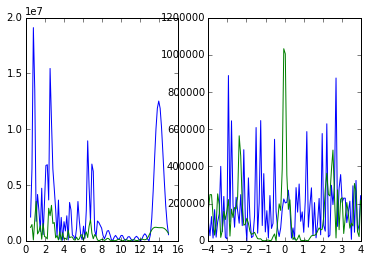

In [14]:
# Execute with 'modifyPower=1' to make the multi-focus spots each correspond to a specfic intensity. 
# Otherwise the total input power will set to the same as in the single focus case, so multi-focal spots 
# will have lower intensity in each spot

modifyPower=0

if modifyPower:
    #Ispta1 = 1.2e7;
    #Ispta1 = Ispta0
    #powerAdj1 = (Ispta1/np.max(I1reg))
    
    powerAdj1=1.5
    Ispta1=powerAdj1*Ispta0
    uamp1adj = sqrt(powerAdj1)*( uamp1  ) 
else:
    Ispta1 = np.max(I1reg)
    powerAdj1=1;
    uamp1adj = sqrt(powerAdj1)*( uamp1  ) 
    

I1 =powerAdj1*I1reg 

xax=np.linspace(-4,4,100)
zax=np.linspace(0.5,15,100)
pr=transducers.calc_pressure_profile(k0, uxyz, uamp0, 1e-2*np.transpose(np.array([np.zeros_like(zax), np.zeros_like(zax), zax])))
pr2=transducers.calc_pressure_profile(k0, uxyz, uamp1adj, 1e-2*np.transpose(np.array([np.zeros_like(zax), np.zeros_like(zax), zax])))

pr3=transducers.calc_pressure_profile(k0, uxyz, uamp1adj, 1e-2*np.transpose(np.array([xax, np.zeros_like(xax), 7+np.zeros_like(xax)])))

pr4=transducers.calc_pressure_profile(k0, uxyz, uamp1adj, 1e-2*np.transpose(np.array([xax, np.zeros_like(xax), 14+np.zeros_like(xax)])))


Iax = np.abs(pr)**2 / (2.0*rho*c0)
Iax2 = np.abs(pr2)**2 / (2.0*rho*c0)
Iax3 = np.abs(pr3)**2 / (2.0*rho*c0)
Iax4 = np.abs(pr4)**2 / (2.0*rho*c0)

plt.subplot(121)
plt.plot(zax,Iax)
plt.plot(zax,Iax2)
#plt.plot(zax, np.max(Iax[-20:-1]) * (14**2 / (14**2 - (zax - 14)**2)))
plt.subplot(122)
plt.plot(xax,Iax3)
plt.plot(xax,Iax4)

In [40]:
xpp = np.arange(-0.03, 0.03, 0.0005);
ypp = xpp;
zpp = np.arange(0.09,0.14, 0.005);
pzfoc = transducers.calc_pressure_field(k0,uxyz,uamp1adj,xpp,ypp,[0.14])
pz09 = transducers.calc_pressure_field(k0,uxyz,uamp1adj,xpp,ypp,[0.13])

In [41]:
focTotal = np.sum(np.abs(pzfoc[:,:,0])**2)

In [27]:
np.sum(np.abs(pzSlc[:,:,:])**2 / focTotal, axis=(0,1) )

NameError: name 'pzSlc' is not defined

In [42]:
pzSlc = transducers.calc_pressure_field(k0,uxyz,uamp1adj,xpp,ypp,zpp);

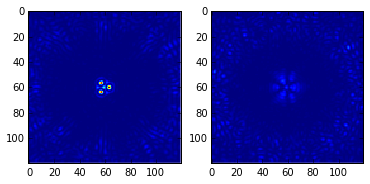

In [43]:
Ifoc = np.abs(pzfoc[:,:,0])**2;
I09 = np.abs(pz09[:,:,0])**2;
plt.subplot(121)
plt.imshow(Ifoc, interpolation="none",vmin=0,vmax=np.max(Ifoc) )
plt.subplot(122)
plt.imshow(I09, interpolation="none",vmin=0,vmax=np.max(Ifoc) )

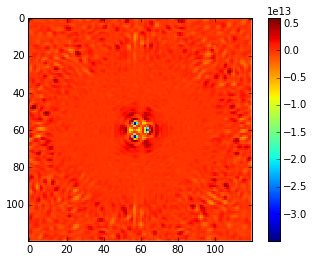

In [53]:
plt.imshow(I09 - Ifoc, interpolation="none")
plt.colorbar()

# Sonication 0

In [15]:
CEM0passFinal = np.zeros([npass0,Nx,Ny,Nz])
Tmax0passFinal = np.zeros([npass0,Nx,Ny,Nz])
T0passFinal = np.zeros([npass0,Nx,Ny,Nz])
CEM0vsTimevsPass = np.zeros([npass0,nacq,Nx,Ny,Nz])
sonicationEndTimesvsPass0 = np.zeros([npass0, nacq])

In [103]:
del CEM0passFinal, Tmax0passFinal, T0passFinal, CEM0vsTimevsPass, sonicationEndTimesvsPass0

In [ ]:


T[0][:]=37
CEM0[:]=0
CEM0vsTime[0][:]=0
Tmax0[:]=0

totalCoolingTime0=0
endTime=0.0;
for n in range(0,npass0):
    print('pass # ', n+1)
    
    Tmax0, sonicationEndTimes0, passtime, coolingTime =sonication_heating_physical_move(t0, coords0Rn[n], uamp0, CEM0, CEM0vsTime, frad=0.002, Tmax=Tmax0, timeZero=endTime, Freeflow=1);
    Tfinal0 = T[0].copy()
    
    CEM0passFinal[n] = CEM0;
    Tmax0passFinal[n] = Tmax0
    T0passFinal[n] = Tfinal0
    CEM0vsTimevsPass[n] = CEM0vsTime;
    sonicationEndTimesvsPass0[n] = sonicationEndTimes0
    totalCoolingTime0 += coolingTime
    endTime = sonicationEndTimes0[-1];
    


In [27]:
gx,gy=np.meshgrid(range(0,Nx), range(0,Ny))

In [43]:
omegaccc = (2*pi)*2;
rr=np.sqrt(gy**2 + gx**2);
for i in range(0,40):
    CEM0vsTimevsPass[0,i,:,:,focplaneZpix] = 240*np.sin( rr*(2*pi) / 5.0 - omegaccc*i)*np.exp(- (rr - omegaccc*i/(2*pi))**2/6)

In [97]:
def animate(i, data, times, interval):
    npass=data.shape[0];
    naqcs =data.shape[1];
    
    passidx = floor(i / naqcs);
    
    frameTime_ms = i*interval;
    dataTime_ms = 1000*times[i];
    
    
    ti = i % naqcs;
    im3=ax3.imshow(np.transpose(data[passidx][ti,:,:,focplaneZpix]), vmin=0,vmax=240, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]])

    im4=ax4.imshow(np.transpose(data[passidx][ti,:,floor(Ny/2),:]), vmin=0,vmax=240, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]])
    
    return (im3,im4)
    

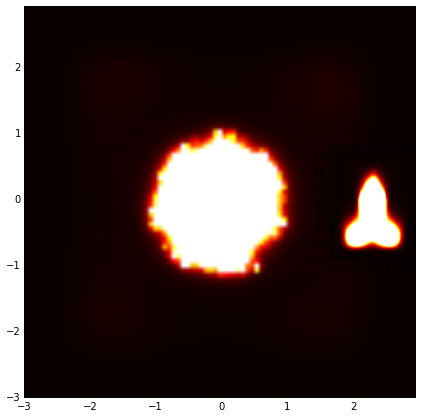

In [98]:
fig=plt.figure(figsize=(7,7))
ax3=fig.add_subplot(111)
#im3=ax3.imshow(np.transpose(CEM0vsTimevsPass[passidx][n,:,:,focplaneZpix]), vmin=0,vmax=240, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]])

ax4=fig.add_subplot(144)
#im4=ax4.imshow(np.transpose(CEM0vsTimevsPass[passidx][n,:,floor(Ny/2),:]), vmin=0,vmax=240, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]])


#t0result = np.cumsum( sonicationEndTimesvsPass0[:] );
#anim = animation.FuncAnimation(fig, animate, fargs=(CEM0vsTimevsPass, t0result, 100), frames=(npass0-1)*nacq, interval=100)

t1result = np.cumsum( sonicationEndTimesvsPass[:] );
anim = animation.FuncAnimation(fig, animate, fargs=(CEM1vsTimevsPass, t1result, 100), frames=(npass1-1)*nacq1, interval=100)
anim.save('C:\\Users\\vchaplin\\Documents\\HiFU\\CEM1test4.mp4')
#plt.show()

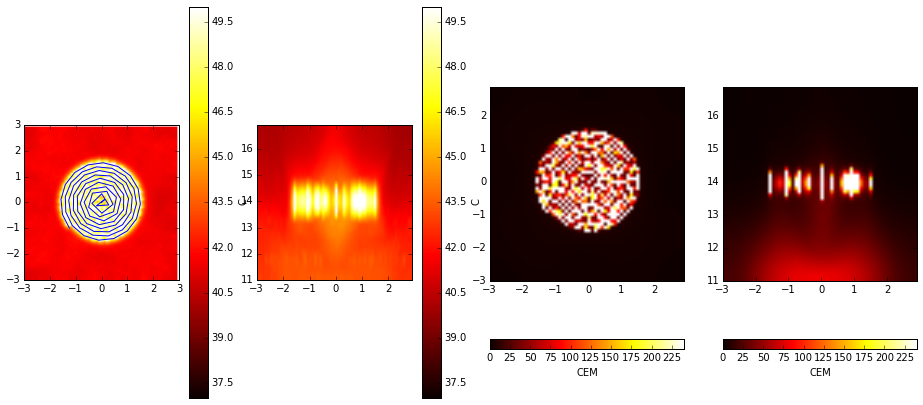

In [32]:
passidx=3
n=-1
fig=plt.figure(figsize=(16,7))
ax1=fig.add_subplot(141)
im1=ax1.imshow(np.transpose(Tmax0passFinal[passidx][:,:,focplaneZpix]), vmin=37,vmax=50, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]])
ax1.plot(x0,y0)

ax2=fig.add_subplot(142)
im2=ax2.imshow(np.transpose(Tmax0passFinal[passidx][:,floor(Ny/2),:]), vmin=37,vmax=50, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]])

ax3=fig.add_subplot(143)
im3=ax3.imshow(np.transpose(CEM0vsTimevsPass[passidx][n,:,:,focplaneZpix]), vmin=0,vmax=240, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]])

ax4=fig.add_subplot(144)
im4=ax4.imshow(np.transpose(CEM0vsTimevsPass[passidx][n,:,floor(Ny/2),:]), vmin=0,vmax=240, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]])


cb1=plt.colorbar(mappable=im1, ax=ax1, orientation='vertical')
cb2=plt.colorbar(mappable=im2, ax=ax2, orientation='vertical')
cb3=plt.colorbar(mappable=im3, ax=ax3, orientation='horizontal')
cb4=plt.colorbar(mappable=im4, ax=ax4, orientation='horizontal')
cb1.set_label('C')
cb2.set_label('C')
cb3.set_label('CEM')
cb4.set_label('CEM')

# Sonication 1

In [17]:
nacq1 = len(t1)-1
CEM1passFinal = np.zeros([npass1,Nx,Ny,Nz])
Tmax1passFinal = np.zeros([npass1,Nx,Ny,Nz])
T1passFinal = np.zeros([npass1,Nx,Ny,Nz])
CEM1vsTimevsPass = np.zeros([npass1,nacq1,Nx,Ny,Nz])
sonicationEndTimesvsPass = np.zeros([npass1, nacq1])

In [21]:
del CEM1passFinal, Tmax1passFinal, T1passFinal, CEM1vsTimevsPass, sonicationEndTimesvsPass

In [21]:
sonicationEndTimesvsPass.shape

(3, 19)

In [ ]:

T[0][:]=37
CEM1[:]=0
CEM1vsTime[0][:]=0
Tmax1[:]=0

endTime=0.0;
totalCoolingTime1=0.0
for n in range(0,npass1):
    print('pass # ', n+1)
    
    Tmax1, sonicationEndTimes, elapsedTime, coolingTime =sonication_heating_physical_move(t1, coords1Rn[n], uamp1adj, CEM1, CEM1vsTime, Tparam=50, frad=0.002, Tmax=Tmax1, timeZero=endTime, Freeflow=1);
    Tfinal1 = T[0].copy()
    
    totalCoolingTime1+=coolingTime
    
    CEM1passFinal[n] = CEM1;
    Tmax1passFinal[n] = Tmax1
    T1passFinal[n] = Tfinal1
    CEM1vsTimevsPass[n] = CEM1vsTime;
    sonicationEndTimesvsPass[n] = sonicationEndTimes
    
    endTime = sonicationEndTimes[-1];
    

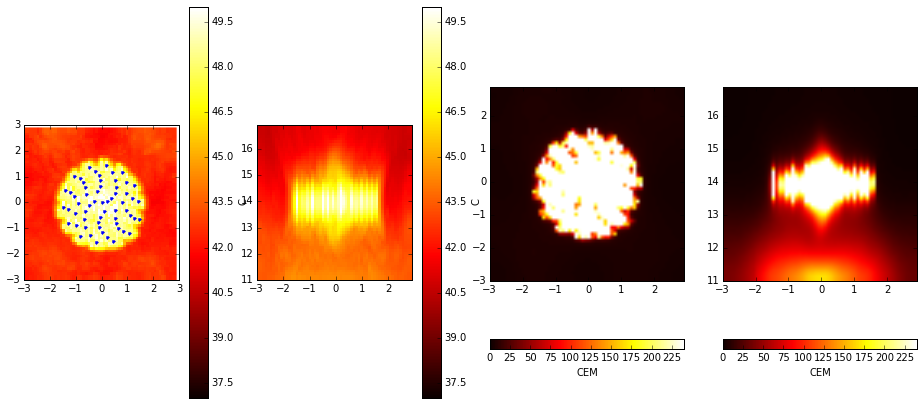

In [34]:
passnum=1


n=-1
fig=plt.figure(figsize=(16,7))
ax1=fig.add_subplot(141)
im1=ax1.imshow(np.transpose(Tmax1passFinal[passnum][:,:,focplaneZpix]), vmin=37,vmax=50, cmap=image.cm.hot, origin='lower', 
               extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]], interpolation="none")
ax1.plot(x1,y1,'.')


ax2=fig.add_subplot(142)
im2=ax2.imshow(np.transpose(Tmax1passFinal[passnum][:,floor(Ny/2),:]), vmin=37,vmax=50, cmap=image.cm.hot, origin='lower', 
               extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]], interpolation="none")

ax3=fig.add_subplot(143)
im3=ax3.imshow(np.transpose(CEM1vsTimevsPass[passnum][n, :,:,focplaneZpix]), vmin=0,vmax=240, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]])
#ax3.plot(x1,y1,'*--')
ax4=fig.add_subplot(144)
im4=ax4.imshow(np.transpose(CEM1vsTimevsPass[passnum][n, :,floor(Ny/2),:]), vmin=0,vmax=240, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]])


cb1=plt.colorbar(mappable=im1, ax=ax1, orientation='vertical')
cb2=plt.colorbar(mappable=im2, ax=ax2, orientation='vertical')
cb3=plt.colorbar(mappable=im3, ax=ax3, orientation='horizontal')
cb4=plt.colorbar(mappable=im4, ax=ax4, orientation='horizontal')
cb1.set_label('C')
cb2.set_label('C')
cb3.set_label('CEM')
cb4.set_label('CEM')


In [33]:
np.max(CEM0)

4324.3144919932356

In [41]:
np.max(CEM0vsTimevsPass[0])

4265.8941908109518

In [333]:
np.mean(T[9][monitorVolPix])

51.0823299466932

In [28]:
sonicationEndTimesvsPass[1]

array([ 20. ,  15.5,  15.7,  20. ,  17.8,  16.9,  18.9,  20. ,  20. ,
        20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ])

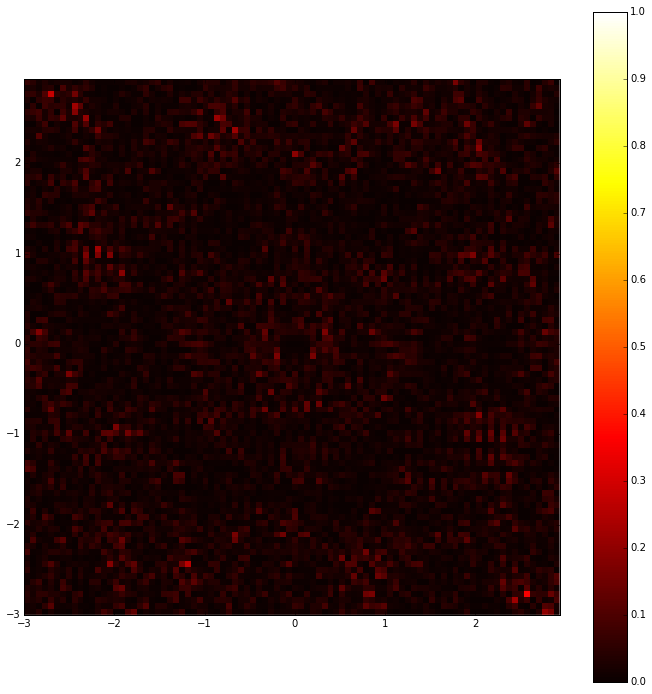

In [137]:
fig=plt.figure(figsize=(12,12))
plt.imshow(np.transpose(I1reg[:,:,1]/maxI), vmax=1, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]], interpolation="none")
#plt.imshow(np.transpose(I1reg[:,floor(Ny/2),:]), cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]], interpolation="none")

plt.colorbar() 

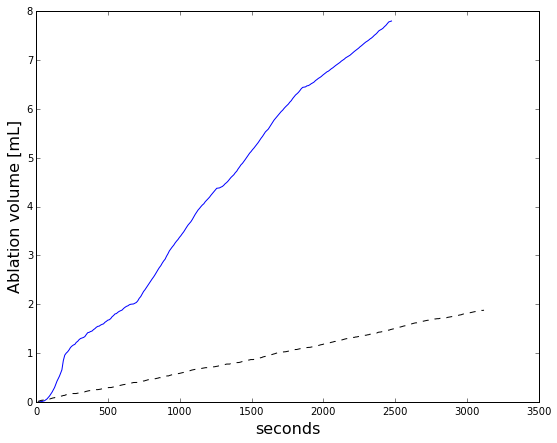

In [28]:
passidx=0; passend=npass1-1;
#passend=1;
t1result = np.cumsum( sonicationEndTimesvsPass[:] );
cemVolCurve=np.zeros_like(t1result);
cem1Curve=np.zeros_like(t1result);

for n in range(0, passend-passidx+1):
    passData = CEM1vsTimevsPass[n+passidx];
    data = passData[:,:,:,roiVolumeZPix];
    cem1Curve[n*nacq1:(n+1)*nacq1] = np.mean(data, (1,2,3));
    cemVolCurve[n*nacq1:(n+1)*nacq1] = 1e6*voxVol*np.sum(np.where(data >= 240.0, 1, 0 ), (1,2,3) );


passidx=0; passend=npass0-1;
#passend=1;
t0result = np.cumsum( sonicationEndTimesvsPass0[:] );
cem0VolCurve=np.zeros_like(t0result);
cem0Curve=np.zeros_like(t0result);

for n in range(0, passend-passidx+1):
    passData = CEM0vsTimevsPass[n+passidx];
    data = passData[:,:,:,roiVolumeZPix];
    cem0Curve[n*nacq:(n+1)*nacq] = np.mean(data, (1,2,3));
    cem0VolCurve[n*nacq:(n+1)*nacq] = 1e6*voxVol*np.sum(np.where(data >= 240.0, 1, 0 ), (1,2,3) );
      

fig=plt.figure(figsize=(9,7))

plt.plot(t1result, cemVolCurve, 'b')
plt.plot(t0result, cem0VolCurve, 'k--')

plt.xlabel('seconds', fontsize=16)
plt.ylabel('Ablation volume [mL]', fontsize=16)

In [85]:
avgrate1=cemVolCurve[-1] / t1result[-1]

In [86]:
avgrate0=cem0VolCurve[-1] / t0result[-1]

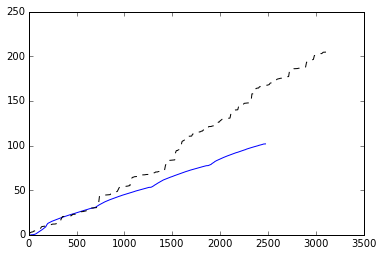

In [29]:
plt.plot(t1result, cem1Curve, 'b')
plt.plot(t0result, cem0Curve, 'k--')

In [79]:
gxp[list(map ( lambda v: np.where( calcGridDist( v ) < 0.002), [np.mean(pxyz,0) + coords1Rn[0][5]] ))[0]]

array([-0.00670588, -0.00670588, -0.00670588, -0.00670588, -0.00670588,
       -0.006     , -0.006     , -0.006     , -0.006     , -0.006     ,
       -0.006     , -0.006     , -0.006     , -0.006     , -0.006     ,
       -0.006     , -0.006     , -0.006     , -0.00529412, -0.00529412,
       -0.00529412, -0.00529412, -0.00529412, -0.00529412, -0.00529412,
       -0.00529412, -0.00529412, -0.00529412, -0.00529412, -0.00529412,
       -0.00529412, -0.00529412, -0.00529412, -0.00529412, -0.00529412,
       -0.00529412, -0.00529412, -0.00529412, -0.00529412, -0.00529412,
       -0.00458824, -0.00458824, -0.00458824, -0.00458824, -0.00458824,
       -0.00458824, -0.00458824, -0.00458824, -0.00458824, -0.00458824,
       -0.00458824, -0.00458824, -0.00458824, -0.00458824, -0.00458824,
       -0.00458824, -0.00458824, -0.00458824, -0.00458824, -0.00388235,
       -0.00388235, -0.00388235, -0.00388235, -0.00388235, -0.00388235,
       -0.00388235, -0.00388235, -0.00388235, -0.00388235, -0.00

In [28]:
passidx=0; passend=npass1-1;
t1result = np.cumsum( sonicationEndTimesvsPass[:] );
t1result2 = t1result[-1]+np.cumsum( sonicationEndTimesvsPass[passidx+1] );
cemVolCurve=np.zeros_like(t1result);
cemVolCurve2=np.zeros_like(t1result2);

for n in range(0, passend-passidx+1):
    passData = CEM1vsTimevsPass[n+passidx];
    data = passData[:,:,:,roiVolumeZPix];
    cemVolCurve[n*nacq:(n+1)*nacq] = 1e6*voxVol*np.sum(np.where(data >= 240.0, 1, 0 ), (1,2,3) );

In [32]:
np.max(Tmax1passFinal,axis=(1,2,3))

array([ 48.91947207,  48.91947207,  48.91947207,  48.91947207])

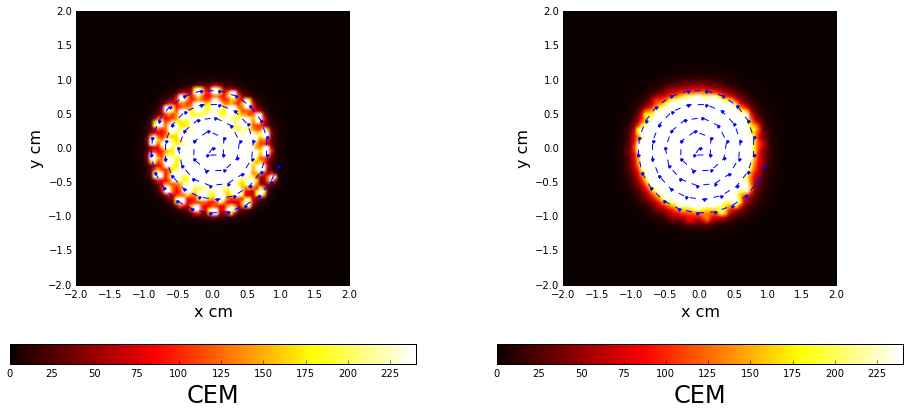

In [75]:
passnum=1
fig=plt.figure(figsize=(16,7))

ax0=fig.add_subplot(121)
im0=ax0.imshow(np.transpose(CEM0vsTimevsPass[passnum][-1, :,:,focplaneZpix]), vmin=0,vmax=240, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]])

ax1=fig.add_subplot(122)
im1=ax1.imshow(np.transpose(CEM1vsTimevsPass[passnum][-1, :,:,focplaneZpix]), vmin=0,vmax=240, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]])

ax0.plot(x0,y0, '.--')
ax1.plot(x1,y1, '.--')

ax0.set_xlabel('x cm', fontsize=16)
ax0.set_ylabel('y cm', fontsize=16)
ax1.set_xlabel('x cm', fontsize=16)
ax1.set_ylabel('y cm', fontsize=16)

cb3=plt.colorbar(mappable=im0, ax=ax0, orientation='horizontal')
cb4=plt.colorbar(mappable=im1, ax=ax1, orientation='horizontal')
cb3.set_label('CEM', fontsize=24)
cb4.set_label('CEM', fontsize=24)


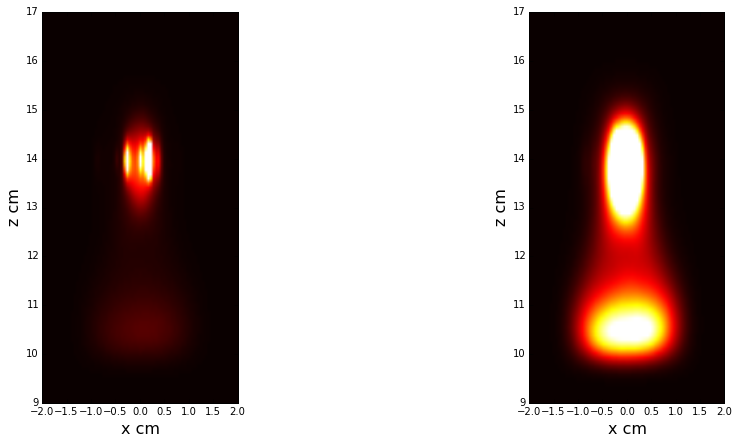

In [92]:
passnum=1
fig=plt.figure(figsize=(16,7))

ax0=fig.add_subplot(121)
im0=ax0.imshow(np.transpose(CEM0vsTimevsPass[passnum][10, :,floor(Ny/2),:]), vmin=0,vmax=240, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]])

ax1=fig.add_subplot(122)
im1=ax1.imshow(np.transpose(CEM1vsTimevsPass[passnum][20, :,floor(Ny/2),:]), vmin=0,vmax=240, cmap=image.cm.hot, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]])

#ax0.plot(x0,y0, '.--')
#ax1.plot(x1,y1, '.--')

ax0.set_xlabel('x cm', fontsize=16)
ax0.set_ylabel('z cm', fontsize=16)
ax1.set_xlabel('x cm', fontsize=16)
ax1.set_ylabel('z cm', fontsize=16)

#cb3=plt.colorbar(mappable=im0, ax=ax0, orientation='horizontal')
#cb4=plt.colorbar(mappable=im1, ax=ax1, orientation='horizontal')
#cb3.set_label('CEM', fontsize=24)
#cb4.set_label('CEM', fontsize=24)


In [265]:
xpp = np.arange(-0.04, 0.04, 0.00025);
ypp = xpp;
zpp = np.arange(0.08,0.18, 0.00025);
#xpp = np.arange(-0.04, 0.04, dx);
#ypp = xpp;
#zpp = np.arange(0.08,0.18, dz);
pxz1 = transducers.calc_pressure_field(k0,uxyz,uamp1adj,xpp,[-0.00151554],zpp)
pxz0 = transducers.calc_pressure_field(k0,uxyz,uamp0,xpp,[0.0],zpp)


fzidx = np.where(np.logical_and( (zpp[1:-1]-0.14>=0) , (zpp[0:-2]-0.14<0) ))[0][0]
Ixz0 = np.abs(pxz0[:,0,:])**2 / (2*rho*c0)
Ixz1 = np.abs(pxz1[:,0,:])**2 / (2*rho*c0)




In [264]:
pxyz

array([[-0.00175   , -0.00151554,  0.14      ],
       [ 0.00175   , -0.00151554,  0.14      ],
       [ 0.        ,  0.00151554,  0.14      ]])

In [266]:
#maxxz0 = np.max(Ixz0[:,fzidx-10:fzidx+10]);
maxxz0 = np.max(Ixz0);



In [257]:
maxxz0/Ispta0

1.5068842981364796

In [267]:
np.max(Ixz0)/np.max(Ixz1)

2.2837518016111087

4895.9885510490285

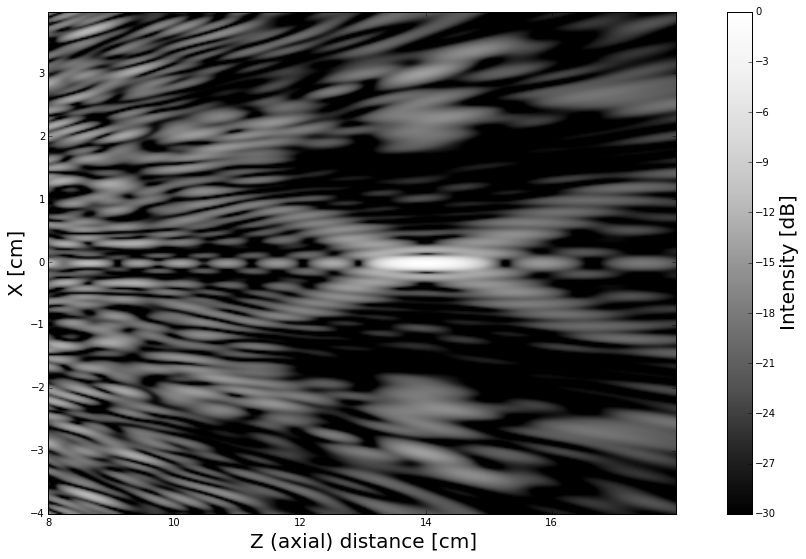

In [268]:
fig=plt.figure(figsize=(18,9))
im=plt.imshow(10*np.log10((Ixz0)/maxxz0), vmin=-30, vmax=0,extent=[100*zpp[0], 100*zpp[-1], 100*xpp[0], 100*xpp[-1]], cmap=image.cm.Greys_r)
plt.xlabel('Z (axial) distance [cm]', fontsize=20)
plt.ylabel('X [cm]', fontsize=20)
cb=plt.colorbar()
cb.set_label('Intensity [dB]', fontsize=20)

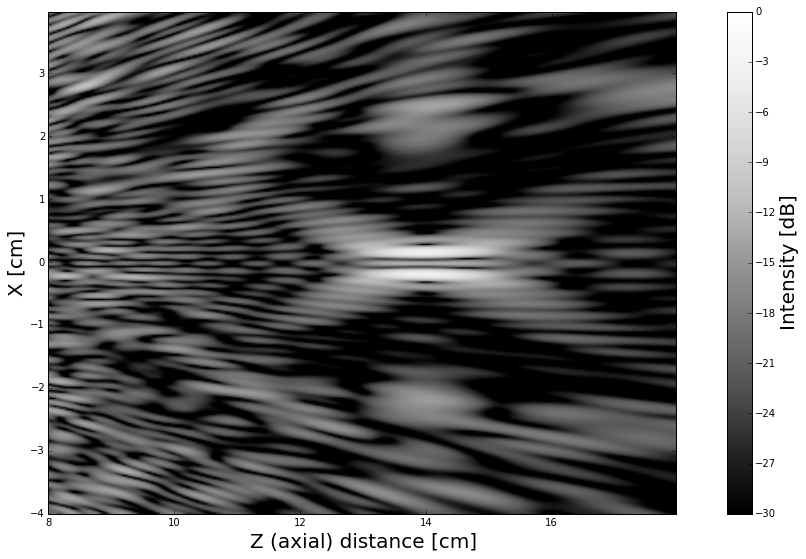

In [272]:
fig=plt.figure(figsize=(18,9))
im=plt.imshow(10*np.log10((Ixz1)/maxxz0), vmin=-30, vmax=0,extent=[100*zpp[0], 100*zpp[-1], 100*xpp[0], 100*xpp[-1]], cmap=image.cm.Greys_r)
plt.xlabel('Z (axial) distance [cm]', fontsize=20)
plt.ylabel('X [cm]', fontsize=20)
cb=plt.colorbar()
cb.set_label('Intensity [dB]', fontsize=20)

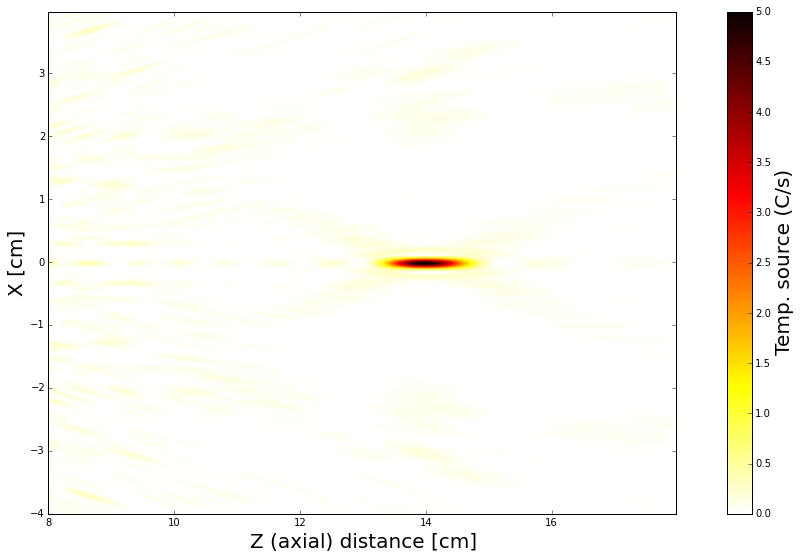

In [275]:
fig=plt.figure(figsize=(18,9))
plt.imshow(2*0.5*Ixz0/(3700*1000),vmin=0,vmax=5,extent=[100*zpp[0], 100*zpp[-1], 100*xpp[0], 100*xpp[-1]], cmap=image.cm.hot_r)
plt.xlabel('Z (axial) distance [cm]', fontsize=20)
plt.ylabel('X [cm]', fontsize=20)
cb=plt.colorbar()
cb.set_label('Temp. source (C/s)', fontsize=20)

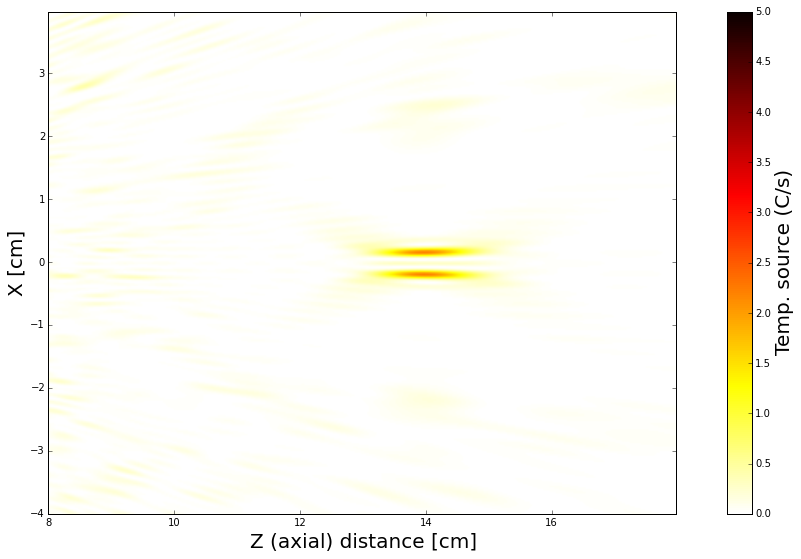

In [276]:
fig=plt.figure(figsize=(18,9))
plt.imshow(2*0.5*Ixz1/(3700*1000),vmin=0,vmax=5,extent=[100*zpp[0], 100*zpp[-1], 100*xpp[0], 100*xpp[-1]], cmap=image.cm.hot_r)
plt.xlabel('Z (axial) distance [cm]', fontsize=20)
plt.ylabel('X [cm]', fontsize=20)
cb=plt.colorbar()
cb.set_label('Temp. source (C/s)', fontsize=20)

In [ ]:
fig=plt.figure(figsize=(18,9))
plt.imshow(10*np.log10((Ixz0)/maxxz0), vmin=-30, vmax=0,extent=[100*zpp[0], 100*zpp[-1], 100*xpp[0], 100*xpp[-1]])
plt.colorbar()

In [194]:
h5name = "C:\\Users\\Vandiver\\Documents\\HiFU\\code\\AblationSims\\cem_spiral_compare.hdf5"

f = h5py.File(h5name, "w")
dset = f.create_dataset("CEM0", data=CEM0vsTimevsPass[passnum][-1])

dset.attrs['xp']=xrp
dset.attrs['zp']=zrp
dset.attrs['yp']=yrp

f.flush()

dset.attrs['Ispta0']=Ispta0
dset.attrs['Ispta']=np.max(I1)

dset1 = f.create_dataset("CEM1", data=CEM1vsTimevsPass[passnum][-1])
dset1.attrs['xp']=xrp
dset1.attrs['zp']=zrp
dset1.attrs['yp']=yrp

f.close()

In [ ]:
h5name = "C:\\Users\\Vandiver\\Documents\\HiFU\code\\AblationSims\\cem0_to_cem1.hdf5"

f = h5py.File(h5name, "w")
dset = f.create_dataset("CEM0", data=CEM0)

dset.attrs['xp']=xrp
dset.attrs['zp']=zrp
dset.attrs['yp']=yrp

f.flush()

dset1 = f.create_dataset("CEM1", data=CEM1)
dset1.attrs['xp']=xrp
dset1.attrs['zp']=zrp
dset1.attrs['yp']=yrp

f.close()